In [1]:
try:
    from google.colab import files
    # We are in colab
    !rm -r stylegan2-keras/
    !git clone https://github.com/leoHeidel/stylegan2-keras.git
    !cp -r stylegan2-keras/* ./

except ImportError:
    # We are not in colab 
    pass

Cloning into 'stylegan2-keras'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 147 (delta 71), reused 98 (delta 30), pack-reused 0
Receiving objects: 100% (147/147), 1.98 MiB | 1.94 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('cifar10', split='train', shuffle_files=True)


#To use another dataset:
#!wget http://address_to_dataset/dataset.zip
#!unzip -q dataset.zip

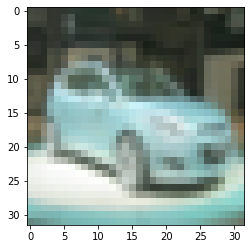

In [3]:
"""
As a eample we will generate more images from one class of the cifar-10 dataset.
Obviously, since the image quality of this dataset is low, 
this in not exceptional.
However this can run quickly enough on colab. 
"""

label = 1
def img_generator():
  for x in ds:
    if x['label'] == label:
      yield tf.cast(x['image'], tf.float32)[...,:3] / 255

im_dataset = tf.data.Dataset.from_generator(img_generator, tf.float32)

#Taking an example:
for im in im_dataset.take(1):
  pass
plt.imshow(im)

for im in im_dataset.take(1):
  pass
plt.imshow(im)

In [4]:
"""
This is the noise we use to generate test examples.
"""
def noise_image(batch_size):
  random_u = np.random.uniform(size = [batch_size, im_size, im_size, 1])
  return random_u.astype('float32')
def latent_z(n):
  return np.random.normal(size=[n, latent_size]).astype('float32')

In [5]:
def evaluate(M,S,G):
  #Generating 9 test examples
  noise = noise_image(9)
  l_z = latent_z(9)
  #model.M map the lattent vector z to w (Notation from the article).
  l_w = M(l_z)
  style = tf.stack([l_w for i in range(model.n_layers)],axis=1)
  #The seed is what the generator start with, in this case, a learnt constant
  seed = S(style)
  #From the seed, the style w and the noise, model.G generate an image.
  generated = G([seed, style,noise])
  #paking them together
  img = tf.concat([tf.concat([generated[3*i+k] for k in range(3)], axis=1) 
                                  for i in range(3)], axis=0)
  return img.numpy()

In [6]:
"""
Building of the style gan model, the parameters are very low, 
to ensure this runs in colab.
"""

import lib_stylegan

im_size = 32
batch_size = 64 
latent_size = 256 
channels = 24 # Should be at least 32 for good results
#Chosing the number of layer this way, means we start with 4x4
nb_layer = int(np.log2(im_size) - 1) 

model = lib_stylegan.style_gan.StyleGan(im_size=im_size, 
                                        latent_size=latent_size, 
                                        channels=channels,
                                        nb_layer=nb_layer)
model.compile(run_eagerly=True)

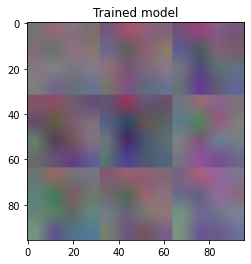

781/781 [==============================] - 338s 432ms/step - disc_loss: 2.8355 - gen_loss: 0.4493 - divergence: 1.3039 - pl_lengths: 0.2231


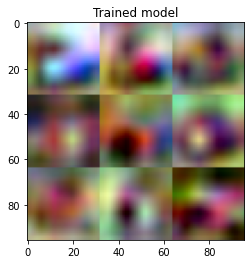

781/781 [==============================] - 329s 421ms/step - disc_loss: 1.8663 - gen_loss: 0.4241 - divergence: 1.2890 - pl_lengths: 0.2892


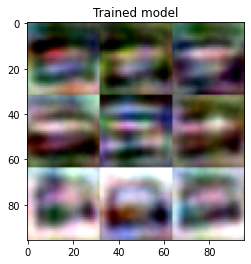

781/781 [==============================] - 325s 416ms/step - disc_loss: 1.9839 - gen_loss: 0.1998 - divergence: 1.6842 - pl_lengths: 0.2969


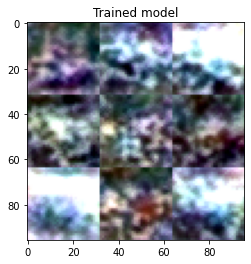

781/781 [==============================] - 326s 418ms/step - disc_loss: 1.9723 - gen_loss: 0.1356 - divergence: 1.7779 - pl_lengths: 0.2966


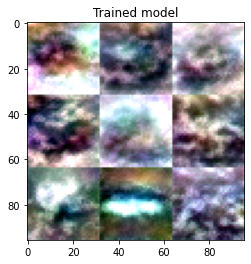

781/781 [==============================] - 327s 419ms/step - disc_loss: 1.9623 - gen_loss: 0.1551 - divergence: 1.7966 - pl_lengths: 0.2908


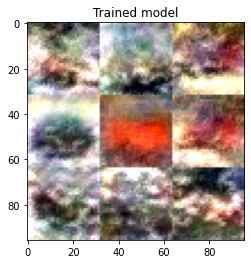

781/781 [==============================] - 323s 413ms/step - disc_loss: 1.9614 - gen_loss: 0.1040 - divergence: 1.8122 - pl_lengths: 0.2786


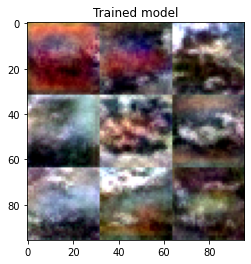

781/781 [==============================] - 322s 412ms/step - disc_loss: 1.9677 - gen_loss: 0.1124 - divergence: 1.8460 - pl_lengths: 0.2670


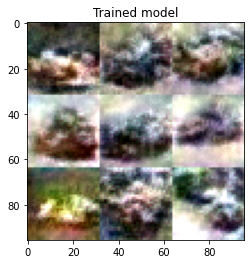

781/781 [==============================] - 323s 414ms/step - disc_loss: 1.9733 - gen_loss: 0.0884 - divergence: 1.8758 - pl_lengths: 0.2540


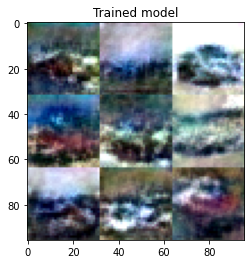

781/781 [==============================] - 325s 416ms/step - disc_loss: 1.9646 - gen_loss: 0.0644 - divergence: 1.8762 - pl_lengths: 0.2438


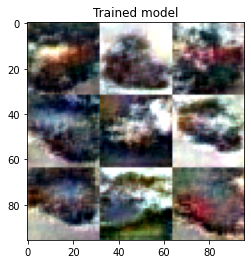

781/781 [==============================] - 324s 415ms/step - disc_loss: 1.9677 - gen_loss: 0.0477 - divergence: 1.8895 - pl_lengths: 0.2318


In [7]:
#This create a corresponding infinite tensorlfow dataset.
dataset = lib_stylegan.dataset.train_dataset_with_tf_dataset(im_dataset, 
                                                             n_layers=nb_layer, 
                                                             im_size=im_size, 
                                                             batch_size=im_size,
                                                             latent_size=latent_size)
#If using own's dataset: 
#dataset = lib_stylegan.dataset.train_dataset(path, n_layers=n_layers, 
#                                                             im_size=im_size, 
#                                                             batch_size=im_size,
#                                                             latent_size=latent_size)

for i in range(10):
  #Generating 9 test examples
  plt.imshow(evaluate(model.M,model.S,model.G))
  plt.title("Trained model")
  plt.show()

  #We manually define the number of steps per epoch as the training dataset is
  #an infinite loop.
  steps_per_epoch = 50000//batch_size
  model.fit(dataset, steps_per_epoch=steps_per_epoch)
  model.save_weights("model.tf")

In [8]:
import tqdm.notebook as tqdm
"""
In order to improve the quality of the gereated images, 
we can take an exponential moving average of the model during training
"""

ema_steps = 1000
model.init_ema()
for example in tqdm.tqdm(dataset.take(ema_steps), total=ema_steps):
  model.train_step(example)
  model.ema_step()

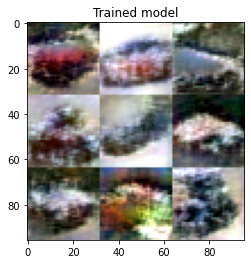

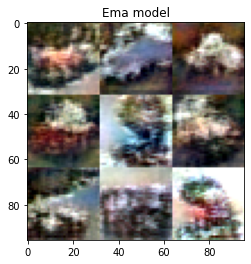

In [9]:
plt.imshow(evaluate(model.M,model.S,model.G))
plt.title("Trained model")
plt.show()

plt.imshow(evaluate(model.ema_M,model.ema_S,model.ema_G))
plt.title("Ema model")
plt.show()

For better training, the model needs to be tained much longer